Optymalizacja procesów dyskretnych
==============

*** Szeregowanie zadań RPQ ***

**Author:** *Marek Kocik 273012*

# Szeregowanie zadań

Celem labolatorium jest ustalenie kolejności realizacji zadań na jednej maszynie w taki sposób, aby zminimalizować łączny czas wykonania wszystkich operacji — tzw. `Cmax`

W ramach poniższych laboratoriów przeanalizowane zostały różne podejścia do problemu:
- **LAB 1** – analiza danych wejściowych i obliczenia bez optymalizacji,
- **LAB 2** – pierwsze próby sortowania i lokalnej optymalizacji kolejności,
- **LAB 3** – zastosowanie algorytmu Schrage’a.

### Oczewikane wyniki
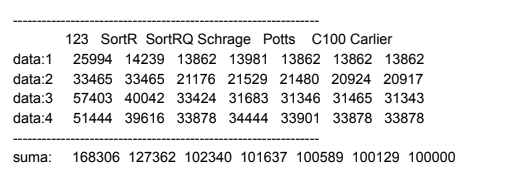

### Przykładowe dane
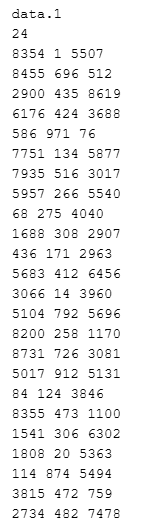

In [1]:
files = ["data1.txt", "data2.txt", "data3.txt", "data4.txt"]

### **LAB 1**

##### Funkcja wczytująca dane i wpisująca je w reprezentanywne tabele

- tabela **r** oznacza ilość chwil czasu od której symulowany produkt może zaczać proces wytwarzania
- tabela **p** oznacza ilość chwil czasu potrzebnych do ukończenia procesu wytwarzania
- tabela **q** oznacza ilość chwil czasu potrzebnych do wystudzenia gotowego produktu


##### Zadania z tabel **r** oraz **q** mogą wykonywać się równoregle
- wszystkie z zdań z tabeli r rozpoczynaja w chwili startu programu
- zadania mogą przejsc do procesu wytwarzania dopiero po upłynieciu czasu z tabeli r dla każdego z zdań
- w procesie produkcji **tabela p** może być poddane tylko jedno z zdań jednocześnie
- ostatecznie zadania musza odczekać faze końcowa reprezentowana przez chwile czasu w tabeli **q**
- w fazie koncowej czas spowrotem plynie rownoregle dla wszystkich **UKOŃCZONYCH** zadań

In [2]:
def loadFromFile(filename):
    r = []
    p = []
    q = []

    with open(filename, 'r') as file:
        file.readline()
        for line in file:
            s = line.strip()
            s = s.split()
            r.append(int(s[0]))
            p.append(int(s[1]))
            q.append(int(s[2]))
    return r,p,q

##### Obliczanie czasu na podstawie nie przetworzonych danych

- dokonujemy obliczeń na kopiach oryginalnych tablic
- iteracyjnie sprawdzamy czy kolejne zadanie jest gotowe do rozpoczęcia procesu wytwarzania
- porównujemy aktualna chwile czasu z chwila czasu potrzebna do rozpoczęcia pracy **tabela r[i]**
- jeśli musimy czekamy do podanej chwili czasu
- następnie możemy zacząć proces wytwarzania
- nastepny produkt może trafić do maszyny dopiero po ukończeniu pracy nad poprzednim **do aktualnej chwili czasu dodanejmy p[i]**
- produkt finalnie bedzie gotowy po czasie z tabeli **q[i]** licząc od aktualnej chwili czasu **czas ukończenia = aktualna chwila + q[i]**

In [3]:
def calculateRaw(r,p,q):
    r,p,q = r.copy(), p.copy(), q.copy()
    Cmax = 0

    for i in range(len(r)):
        if r[i] >  Cmax:
            Cmax = r[i]
        Cmax = Cmax + p[i]
        q[i] = Cmax + q[i]

    maxCooling = max(q)

    if maxCooling > Cmax:
        Cmax = maxCooling

    return Cmax

##### Finalnie możemy sprawdzić wynik pracy algorytmu **168306**

Wyniki pokrywaja sie z oczekiwanymi

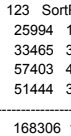

In [4]:
sum = 0
for file in files:
    r,p,q = loadFromFile(file)
    sum = sum + calculateRaw(r,p,q)
print(sum)

168306


### **LAB 2**

Labolatorium drugie polegało na poprawie pracy algorytmu poprzez

- Posortowanie wszystkich zadań względem chwil czasów przygotowania do produkcji **(tabela r)**
- Przeanalizowania przestrzeni rozwiazań dla uzyskanej kolejności

##### Pierwsza funkcja sortuje nam tabele zachowując kolejność w reprezentatywnych tabelach

##### Finalnie możemy porównać osiągnięty wynik z oczekiwanym z tabeli **127362**


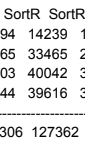

In [5]:
def SortR(r,p,q, reverse=False):  
    zipped = zip(r,p,q)
    r, p, q = zip(*sorted(zipped, reverse=reverse))
    r  = list(r)
    p  = list(p)
    q  = list(q)
    return r, p, q

sum = 0
bestSum = float('inf')
for file in files:
    r,p,q = loadFromFile(file)
    r, p, q = SortR(r,p,q, reverse=False)
    sum += calculateRaw(r,p,q)
print(sum)

127362


##### Jako przestrzeń bierzemy wszystkie rozwiazania osiagane w wyniku zamieniania miejscami dwóch sasiednich zadań

Tworzymy kopie oryginalnej tablicy po czym podmieniamy wartości w miejscu aktualnego iteratora na jego nastepnego sasiada.
Obliczamy wynik dla aktualnej kombinacji, nastepnie porównojemy wynik z aktualnie najlepszym.
Kroki powtarzamy przesuwajac każdy element od jego pozycji poczatkowej do ostatniej dostępnej pozycji.

##### W tym przypadku osiagamy lekką poprawe względem zwykłego sortowania **112518**

In [6]:
def findSolutionFields(r, p, q, bestSum):
    best_Cmax = bestSum
    for i in range(len(r)):
        for j in range(i+1, len(r)):
            new_r, new_p, new_q = r.copy(), p.copy(), q.copy()
            new_r[i], new_r[j] = new_r[j], new_r[i]
            new_p[i], new_p[j] = new_p[j], new_p[i]
            new_q[i], new_q[j] = new_q[j], new_q[i]
            
            current_Cmax = calculateRaw(new_r, new_p, new_q)
            if current_Cmax < best_Cmax:
                best_Cmax = current_Cmax
    
    return best_Cmax

sum = 0
bestSum = 0
for file in files:
    r,p,q = loadFromFile(file)
    r,p,q = SortR(r,p,q)
    bestSum = calculateRaw(r,p,q)
    bestSum = findSolutionFields(r, p, q,bestSum)
    sum += bestSum
print(sum)

112518


### **LAB 3**

Labolatorium nr 3 ponownie polegało na optymalizacji problemu szeregowania zadań na jednej maszynie tym razem z wykorzystaniem algorytmu Schrage

##### Algorytm Schrage'a
Algorytm Schrage’a służy do minimalizacji maksymalnego czasu zakończenia (Cmax).
Algorytm opiera się na dwóch zbiorach:

- Zbiór zadań niewgotowych (N) – jeszcze niedostępne,
- Zbiór zadań gotowych (G) – dostępne do wykonania.

W każdej iteracji wybierane jest zadanie z największym q_i spośród dostępnych.

In [ ]:
import heapq

def Schrage(r, p, q):
    tasks = list(zip(r, p, q, range(len(r))))
    tasks.sort()
    
    ready = []
    time = 0
    Cmax = 0
    i = 0
    
    while i < len(tasks) or ready:
        while i < len(tasks) and tasks[i][0] <= time:
            r_i, p_i, q_i, idx = tasks[i]
            heapq.heappush(ready, (-q_i, p_i, r_i, idx))
            i += 1
        
        if not ready:
            time = tasks[i][0]
            continue
            
        neg_q, p_i, r_i, idx = heapq.heappop(ready)
        q_i = -neg_q
        
        time += p_i
        Cmax = max(Cmax, time + q_i)
    
    return Cmax

In [ ]:
sum = 0
for file in files:
    r,p,q = loadFromFile(file)
    r,p,q = SortR(r,p,q)
    sum += Schrage(r,p,q)
print(sum)

101148
